In [1]:
#Let us validate our model
#We use a separate file called benchmark. These datasets contain strain/stresses outside our trained regime
#This serves to validate our model whether it can predict extrapolated conditions
#Then we use the optimised deep learning model to predict based on these datasets and plot it
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow import keras
from keras import layers
import keras_tuner as kt

In [150]:
data1 = pd.read_csv("benchmark(-0.2--0.1).dat") #testing dataset with negative strain values
data2 = pd.read_csv("benchmark(0.1-0.2).dat") #testing dataset with positive strain values
data = pd.concat([data1, data2])
data.head()

load_index  time   eps     eps_V     str_s     str_d       str      Wsto  \
0         0.0   0.0  0.00  0.000000  0.000000  0.000000  0.000000  0.000000   
1         0.0   1.0 -0.01 -0.000098 -0.000098 -0.009804 -0.009902  0.000098   
2         0.0   2.0 -0.02 -0.000292 -0.000292 -0.019416 -0.019708  0.000193   
3         0.0   3.0 -0.03 -0.000581 -0.000581 -0.028839 -0.029419  0.000286   
4         0.0   4.0 -0.04 -0.000961 -0.000961 -0.038077 -0.039039  0.000376   

           Wdis    Wtotal      Esto          Edis    Etotal  
0  0.000000e+00  0.000000  0.000000  0.000000e+00  0.000000  
1  9.611688e-07  0.000099  0.000098  9.611688e-07  0.000099  
2  3.769659e-06  0.000197  0.000291  4.730828e-06  0.000296  
3  8.316783e-06  0.000294  0.000577  1.304761e-05  0.000590  
4  1.449880e-05  0.000390  0.000953  2.754641e-05  0.000981

In [151]:
dataset = data.copy()
df = np.zeros((len(dataset)-1,5))
df[:,0] = dataset.iloc[:-1,2]
df[:,1] = dataset.iloc[1:,2]
df[:,2] = dataset.iloc[:-1,3]
df[:,3] = dataset.iloc[1:,3]
df[:,4] = dataset.iloc[1:,6]
column_names = ["eps", "eps_n1", "eps_V", "eps_V_n1", "str_n1"]
df = pd.DataFrame(df, columns=column_names)
df.head()

eps  eps_n1     eps_V  eps_V_n1    str_n1
0  0.00   -0.01  0.000000 -0.000098 -0.009902
1 -0.01   -0.02 -0.000098 -0.000292 -0.019708
2 -0.02   -0.03 -0.000292 -0.000581 -0.029419
3 -0.03   -0.04 -0.000581 -0.000961 -0.039039
4 -0.04   -0.05 -0.000961 -0.001433 -0.048567

In [153]:
#FFNN-1
num_data = 2020000
x = df.iloc[:num_data, :3].to_numpy()
y = df.iloc[:num_data, 3:].to_numpy()

In [154]:
#FFNN-2
num_data = 2020000

x2 = df.iloc[:num_data, 0].to_numpy()
y2 = df.iloc[:num_data, -1].to_numpy()

In [155]:
#RNN
ts = 101
num_data = 2020000//ts

X, Y = list(), list()

for i in range(0, num_data):
    X.append(df.iloc[i*ts:(i+1)*ts, [0]])
    Y.append(df.iloc[i*ts:(i+1)*ts, [-1]])

X, Y = np.array(X), np.array(Y)

In [113]:
#Check if the dimensions are correct
print(x.shape, y.shape)
print(x2.shape, y2.shape)
print(X.shape, Y.shape)

(2020000, 3) (2020000, 2)
(2020000,) (2020000,)
(20000, 101, 1) (20000, 101, 1)


In [57]:
#Load the optimised model
model_FFNN_1 = keras.models.load_model("1D_FFNN_1.h5")
model_FFNN_2 = keras.models.load_model("1D_FFNN_2.h5")
model_RNN = keras.models.load_model("1D_RNN.h5")
history_FFNN_1 = pd.read_csv("1D_history_FFNN_1.csv")
history_FFNN_2 = pd.read_csv("1D_history_FFNN_2.csv")
history_RNN = pd.read_csv("1D_history_RNN.csv")

In [60]:
def plot_epoch(nom):
    plt.figure(dpi=120)
    plt.title(f"{nom-1} epochs", fontsize=18)
    plt.yscale(value="log")

    plt.ylabel("Mean Squared Error", fontsize=18)
    plt.xlabel("Epochs", fontsize=18)
    
    plt.plot(history_FFNN_1["mean_squared_error"][:nom], label="FFNN_1")
    plt.plot(history_FFNN_2["mean_squared_error"][:nom], label="FFNN_2")
    plt.plot(history_RNN["mean_squared_error"][:nom], label="RNN")
    
    plt.tight_layout()
    plt.legend()
    #plt.savefig(f"./history/MSE_History_full_{nom}.jpg", format="jpg")
    plt.show()

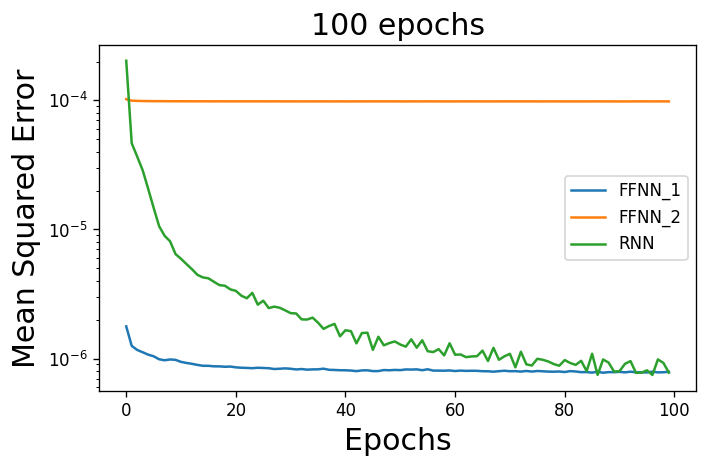

In [64]:
nom = [6, 26, 51, 101]
nom = [101]
for i in nom:
    plot_epoch(i)

In [68]:
def plot_epoch_successive(label):
    history = "history_"+ label
    plt.figure(dpi=120)
    plt.title("MSE for successive epochs")
    plt.yscale(value="log")

    plt.ylabel("Mean Squared Error", fontsize=18)
    plt.xlabel("Epochs", fontsize=18)
    plt.plot(globals()[history]["mean_squared_error"], label=label)
    plt.tight_layout()
    plt.legend()
    #plt.savefig(f"./history/MSE_History_{label}.jpg", format="jpg")
    plt.show()
    

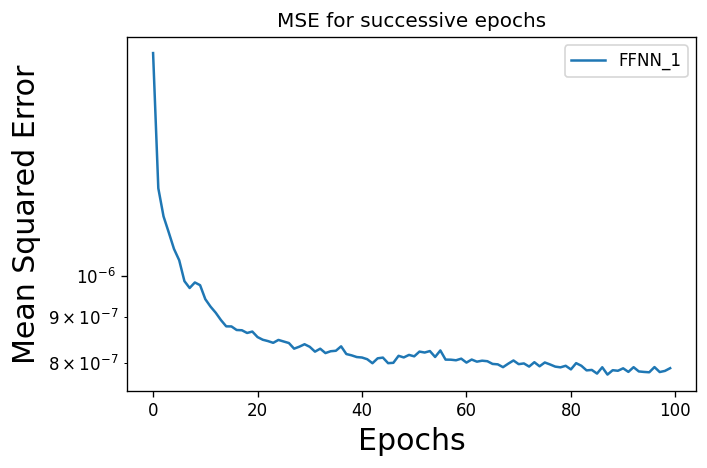

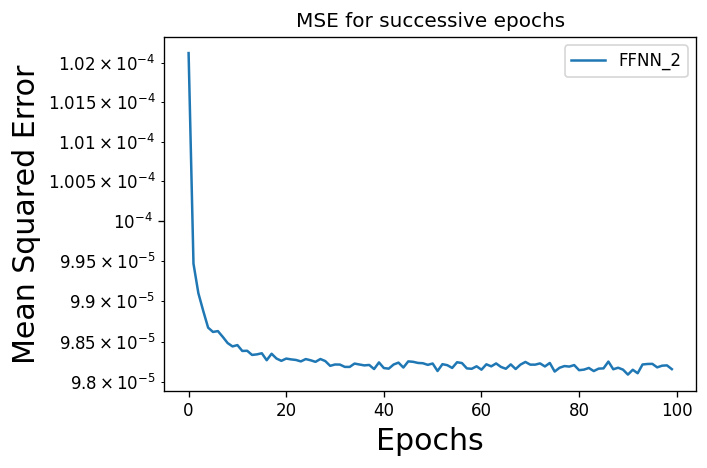

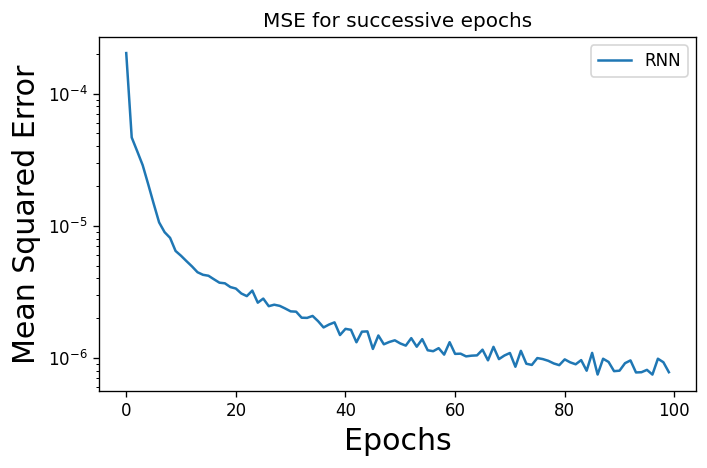

In [69]:
label = ["FFNN_1", "FFNN_2", "RNN"]
for i in label:
    plot_epoch_successive(i)

In [140]:
y_pred_FFNN_1 = model_FFNN_1.predict(x)
y_pred_FFNN_2 = model_FFNN_2.predict(x2)
y_pred_RNN = model_RNN.predict(X)

In [133]:
def plot_all(sel):
    plt.figure(dpi=180)
    plt.title(f"Comparison for loading history No. {sel}")
    #plt.yscale("symlog")
    plt.plot(x[sel*ts:(sel+1)*ts, 0], y[sel*ts:(sel+1)*ts,-1], label="Ground Truth", linewidth=4, marker="o")
    plt.plot(x[sel*ts:(sel+1)*ts,0], y_pred_FFNN_1[sel*ts:(sel+1)*ts,-1],label="Pred_FFNN_1", marker = "o", linestyle='--', linewidth=0.5)
    plt.plot(x2[sel*ts:(sel+1)*ts], y_pred_FFNN_2[sel*ts:(sel+1)*ts], label="Pred_FFNN_2", marker = "^",linestyle='--', linewidth=0.5)
    plt.plot(X[sel,:], y_pred_RNN[sel], label="Pred_RNN", marker = "s", linewidth=0.5, markerfacecolor="None")

    plt.ylabel("$\sigma_{11}$")
    plt.xlabel("$\epsilon_{11}$")
    plt.legend()
    plt.tight_layout()
    #plt.savefig(f"./plot_bench/Bench_All_{sel}.jpg", format="jpg")
    plt.show()

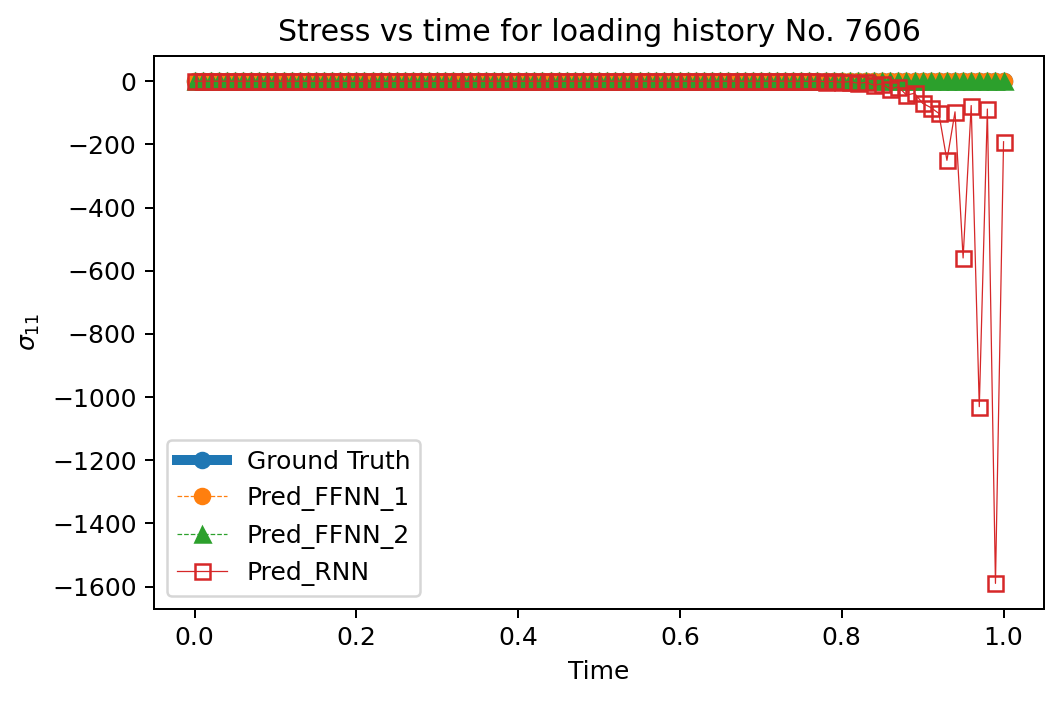

In [143]:
plt.figure(dpi=180)
sel = np.random.randint(0, 20001)
x_axis = np.linspace(0,1,101)
plt.title(f"Stress vs time for loading history No. {sel}")
plt.plot(x_axis, y[sel*ts:(sel+1)*ts,-1], label="Ground Truth", linewidth=4, marker="o")
plt.plot(x_axis, y_pred_FFNN_1[sel*ts:(sel+1)*ts,-1],label="Pred_FFNN_1", marker = "o", linestyle='--', linewidth=0.5)
plt.plot(x_axis, y_pred_FFNN_2[sel*ts:(sel+1)*ts], label="Pred_FFNN_2", marker = "^",linestyle='--', linewidth=0.5)
plt.plot(x_axis, y_pred_RNN[sel], label="Pred_RNN", marker = "s", linewidth=0.5, markerfacecolor="None")

plt.ylabel("$\sigma_{11}$")
plt.xlabel("Time")
plt.legend()
plt.tight_layout()
#plt.savefig(f"./plot_bench/Stress_time_All_{sel}.jpg", format="jpg")
plt.show()

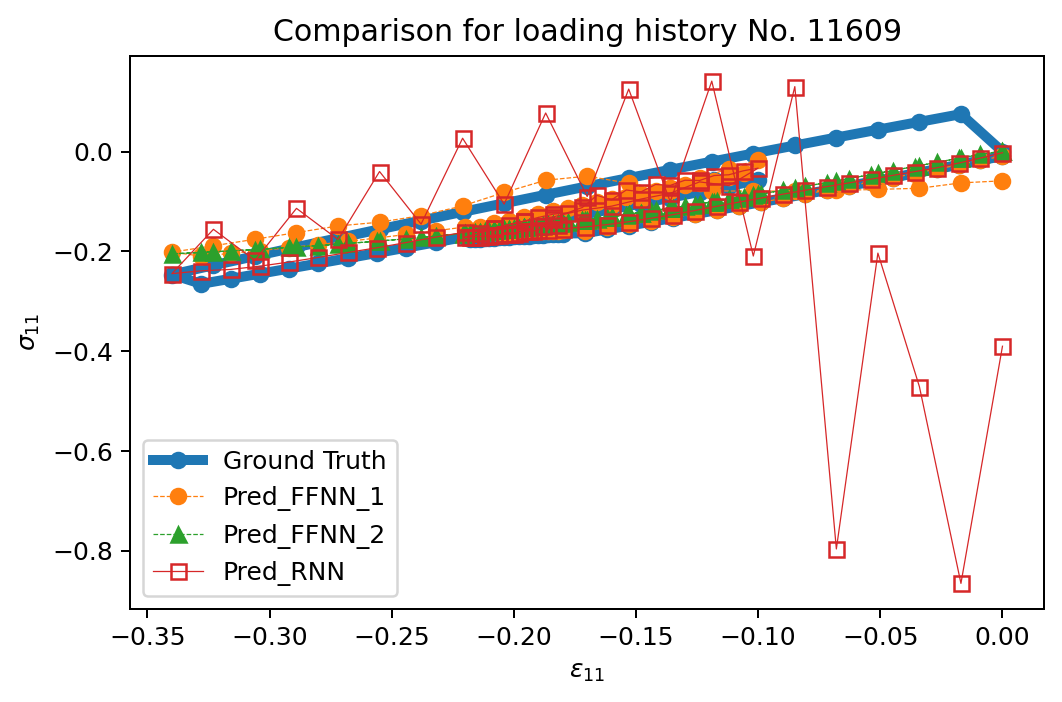

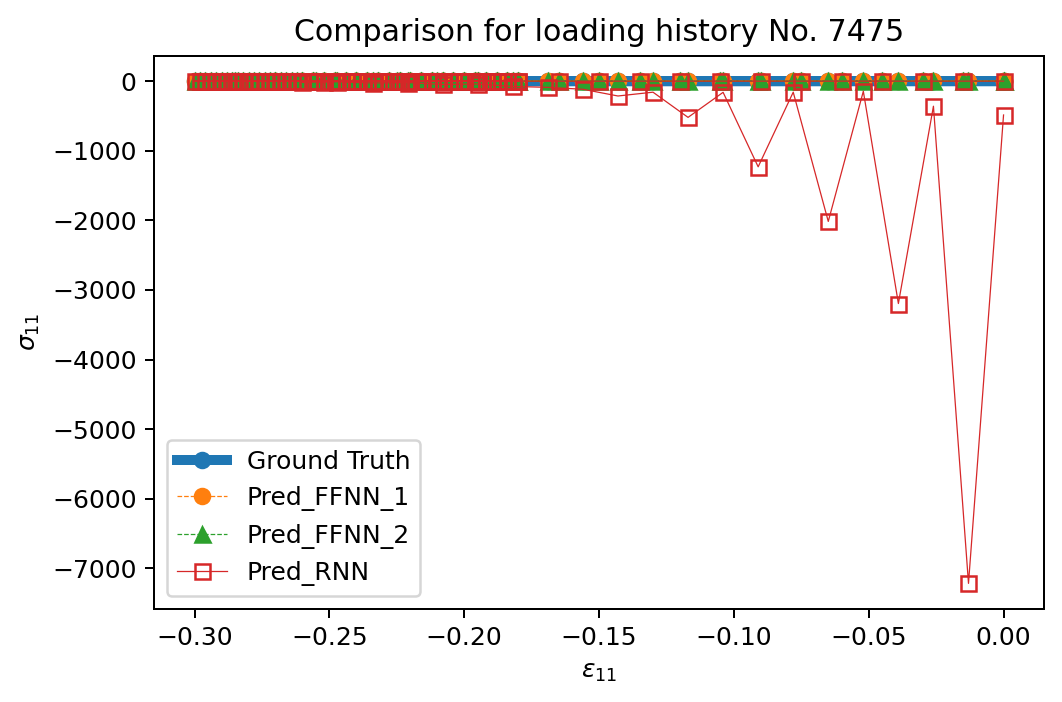

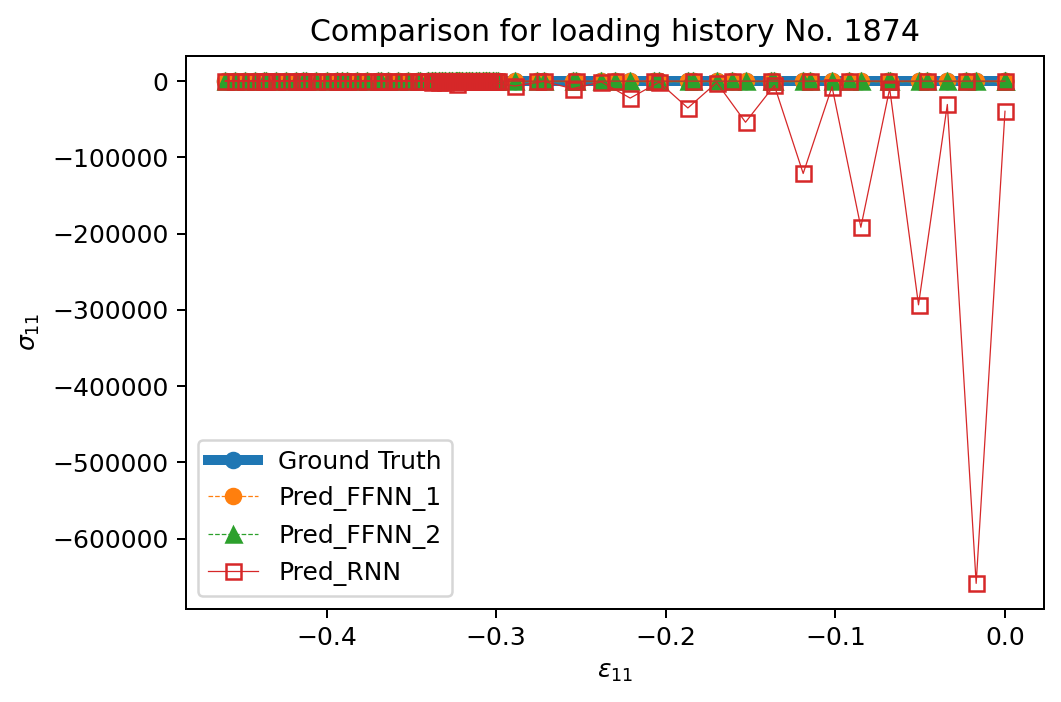

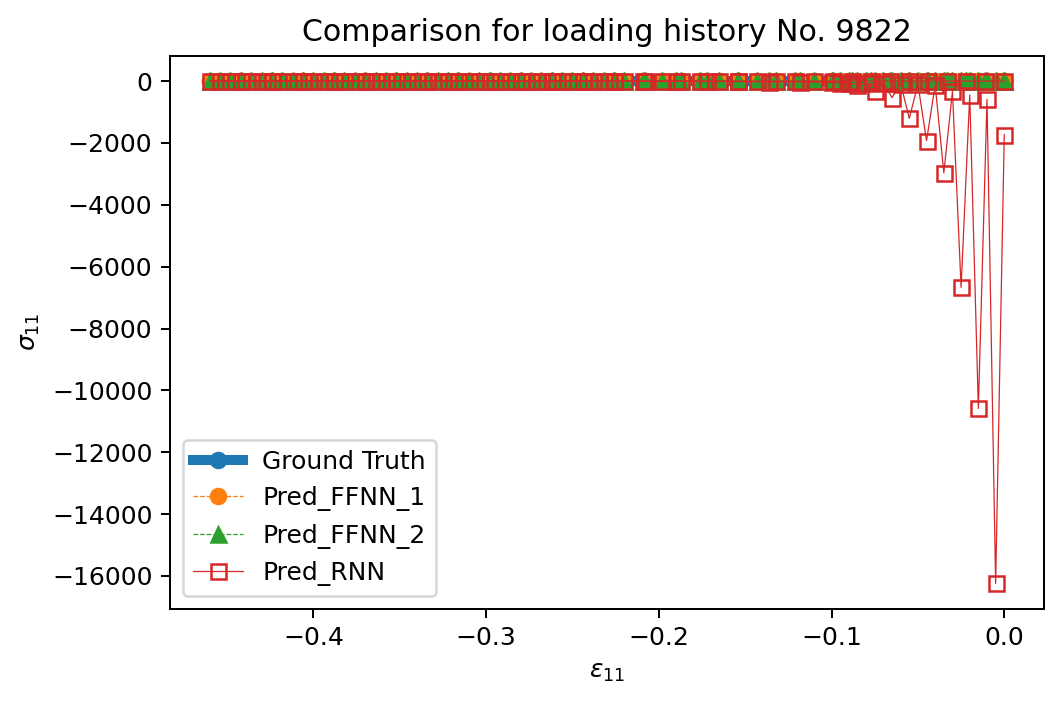

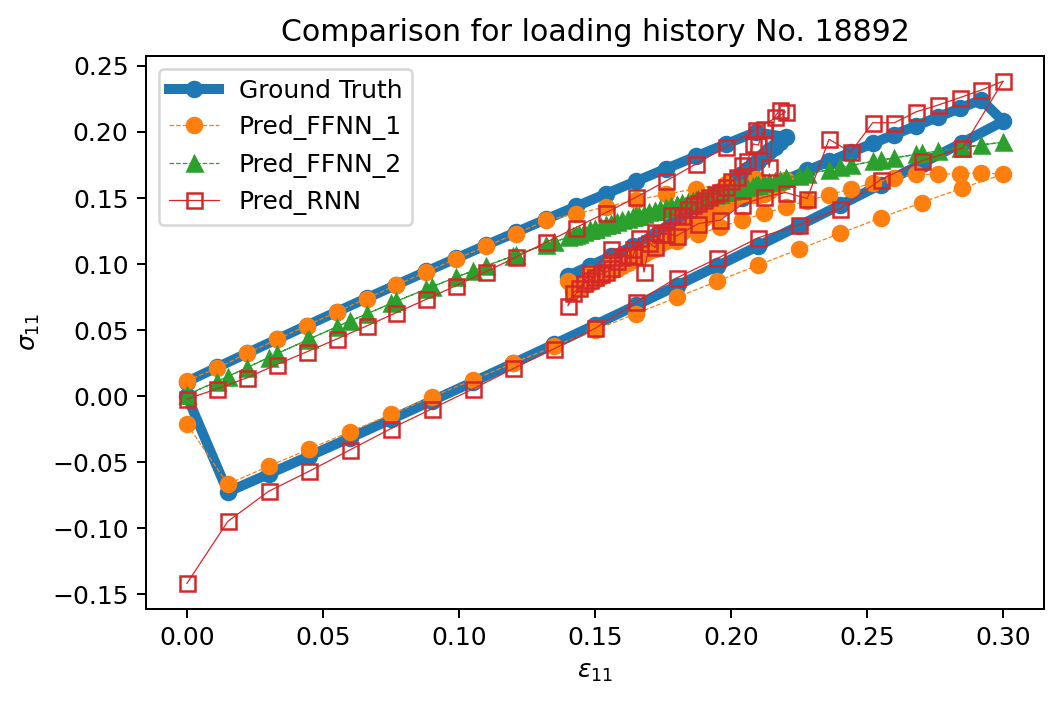

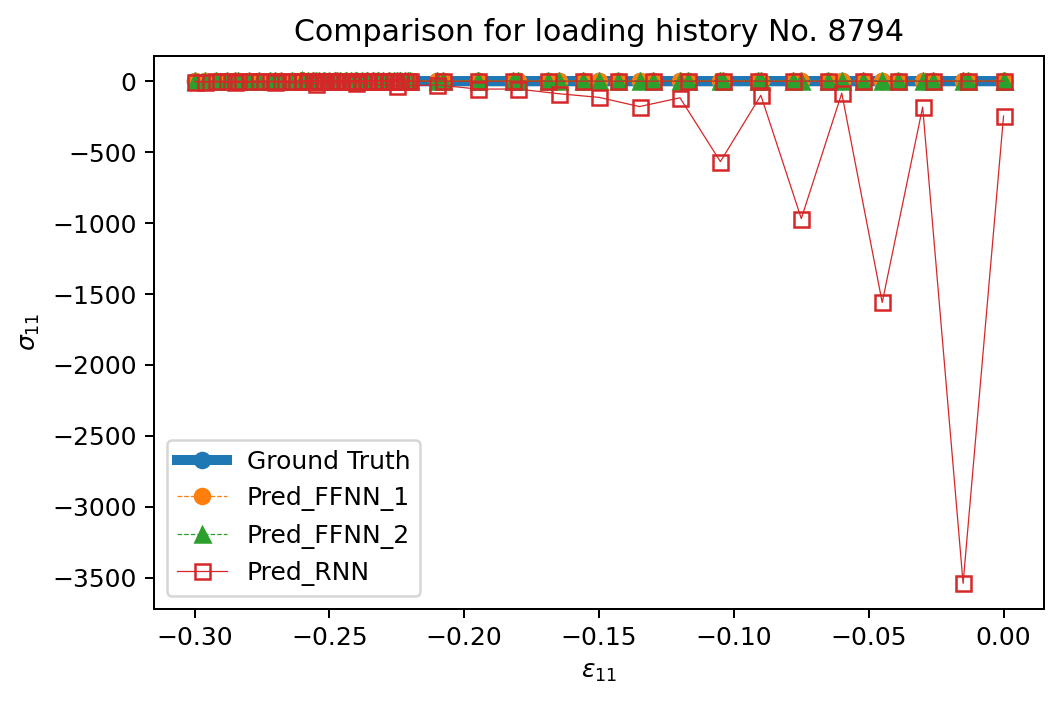

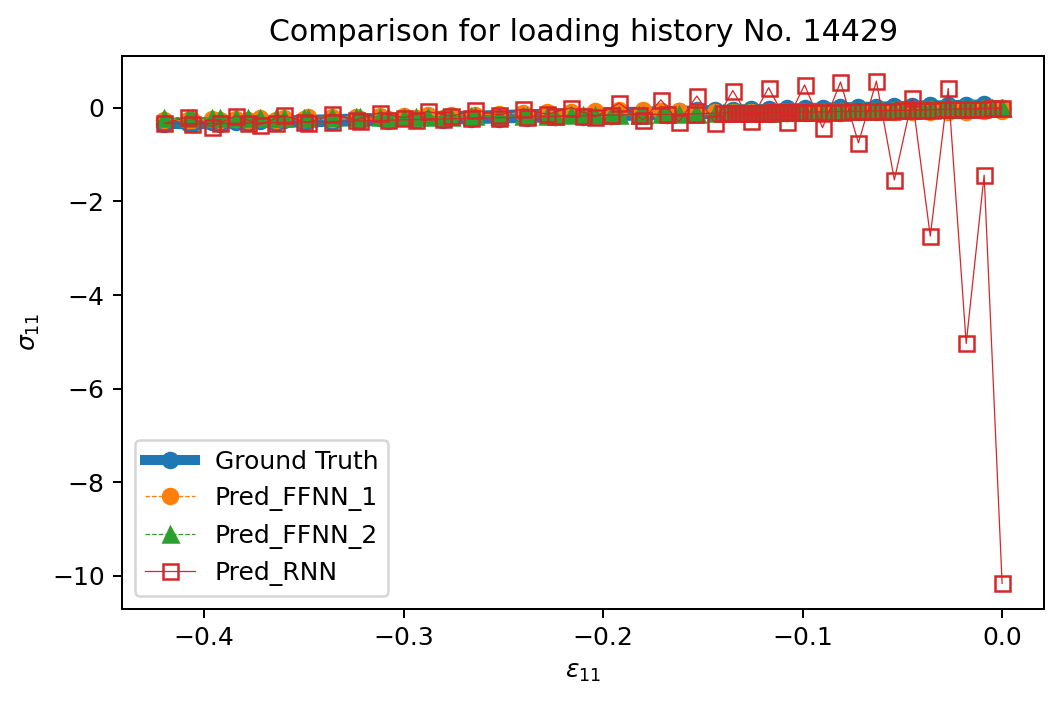

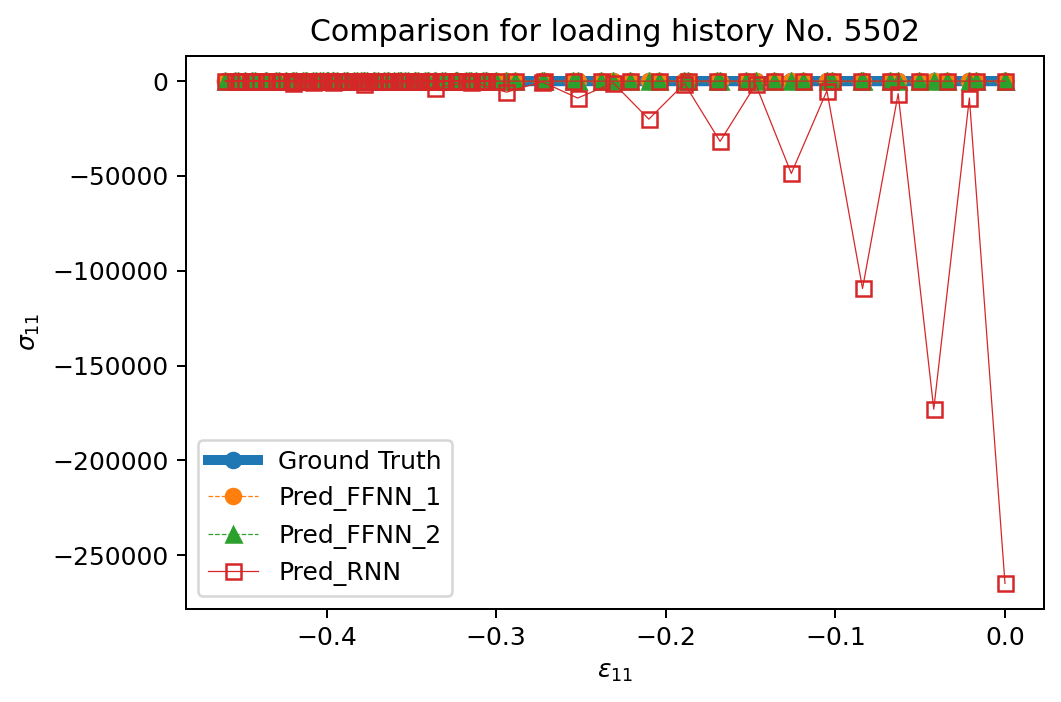

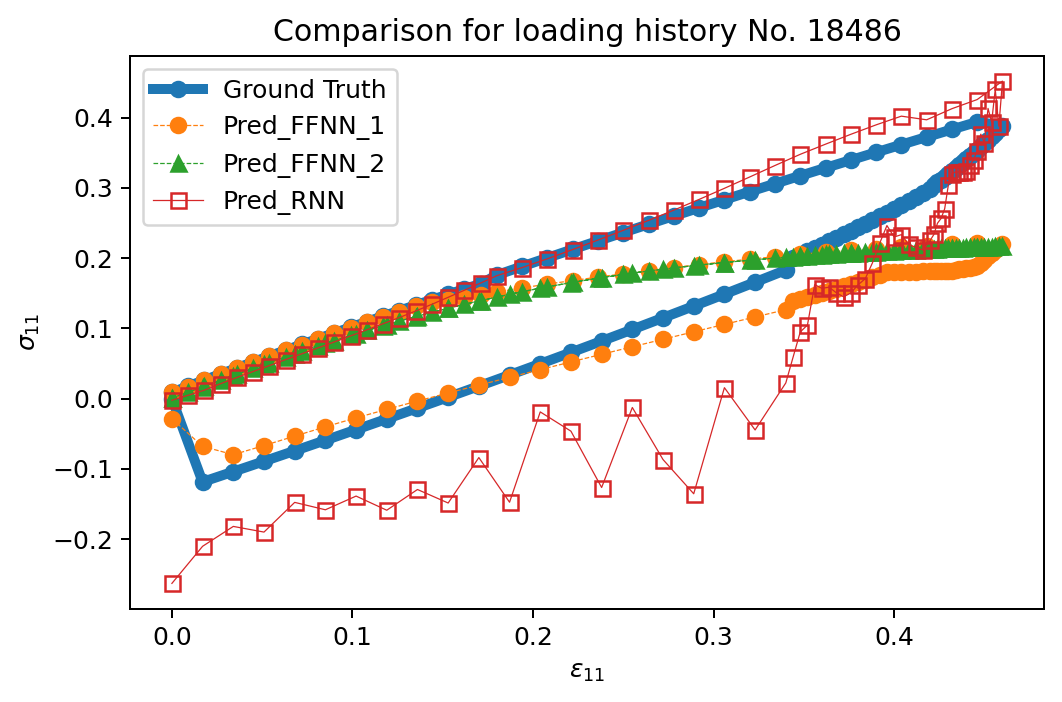

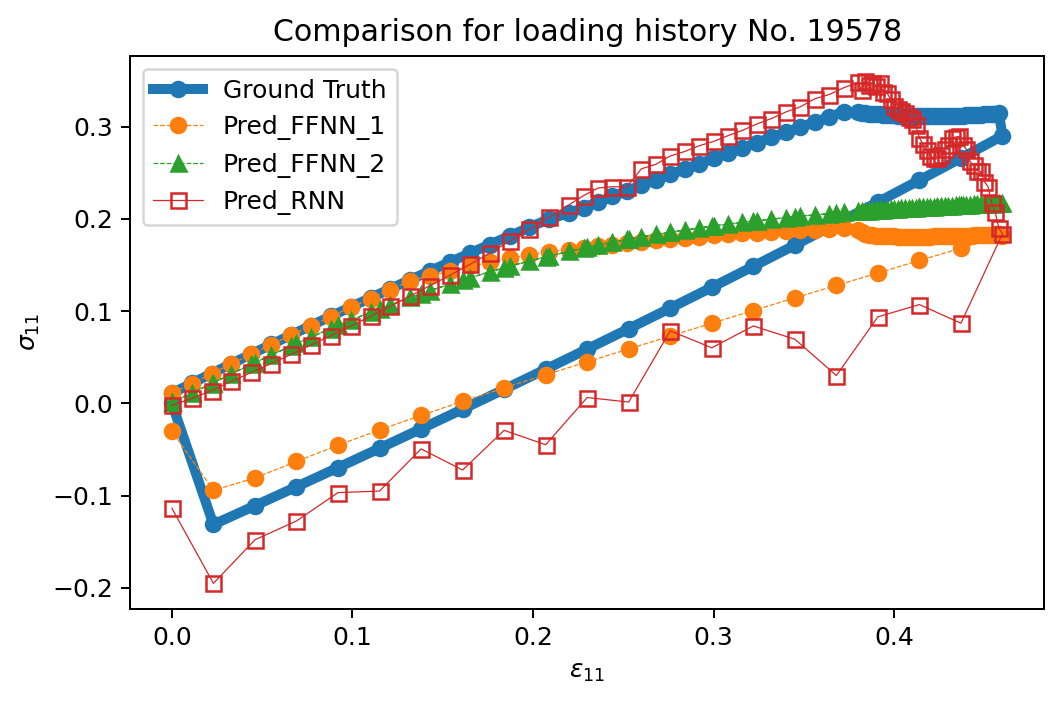

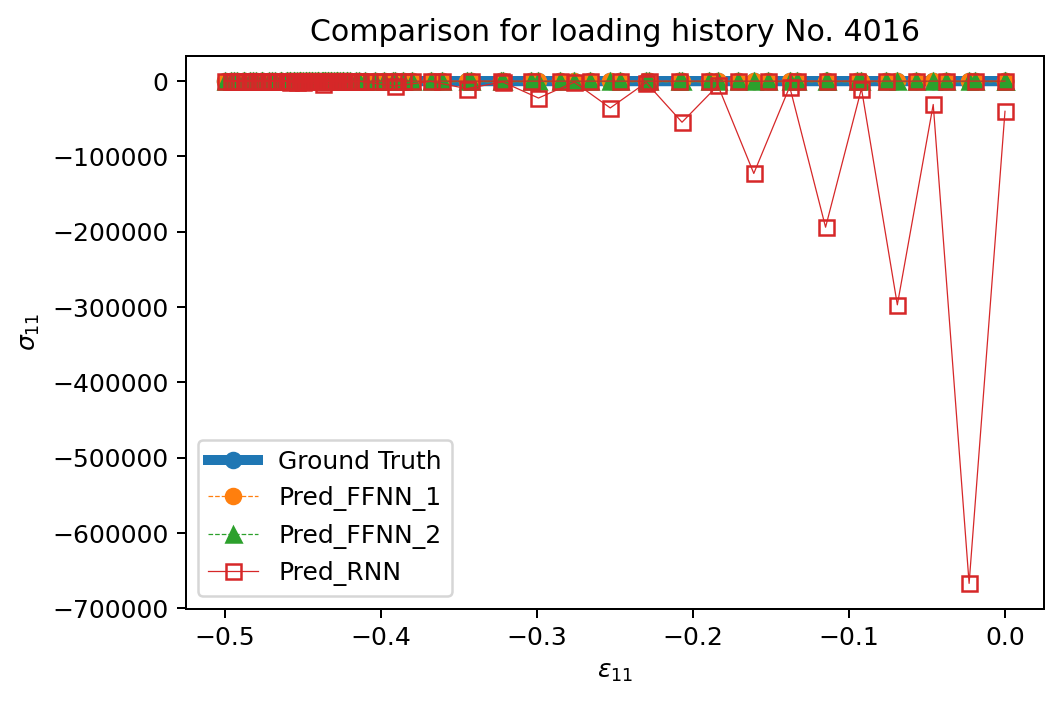

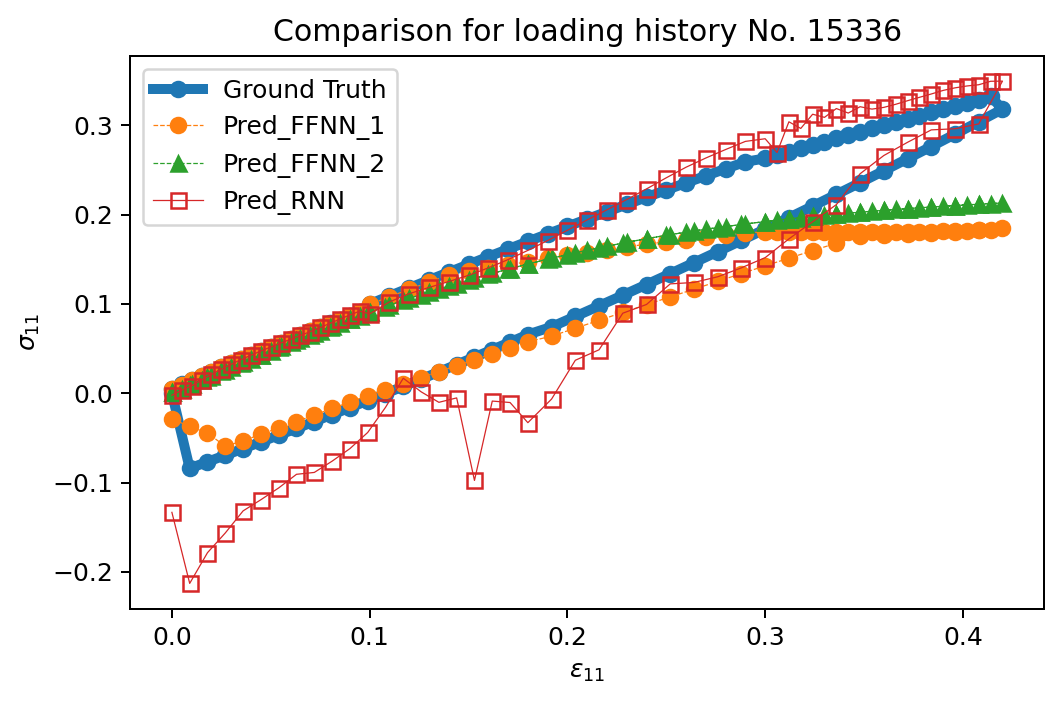

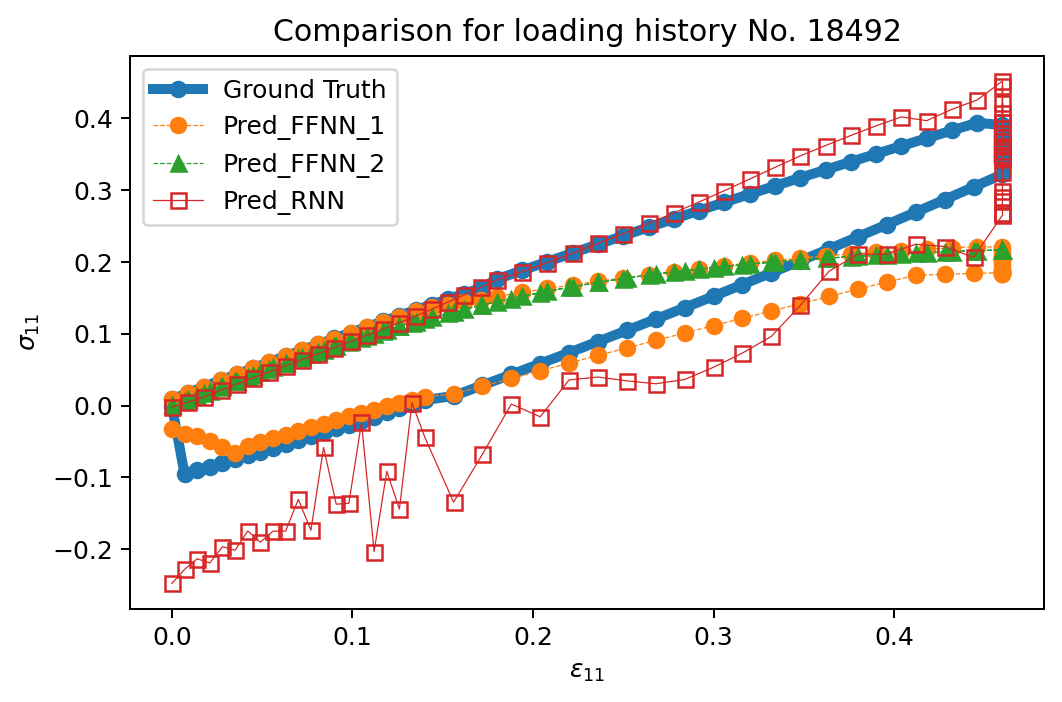

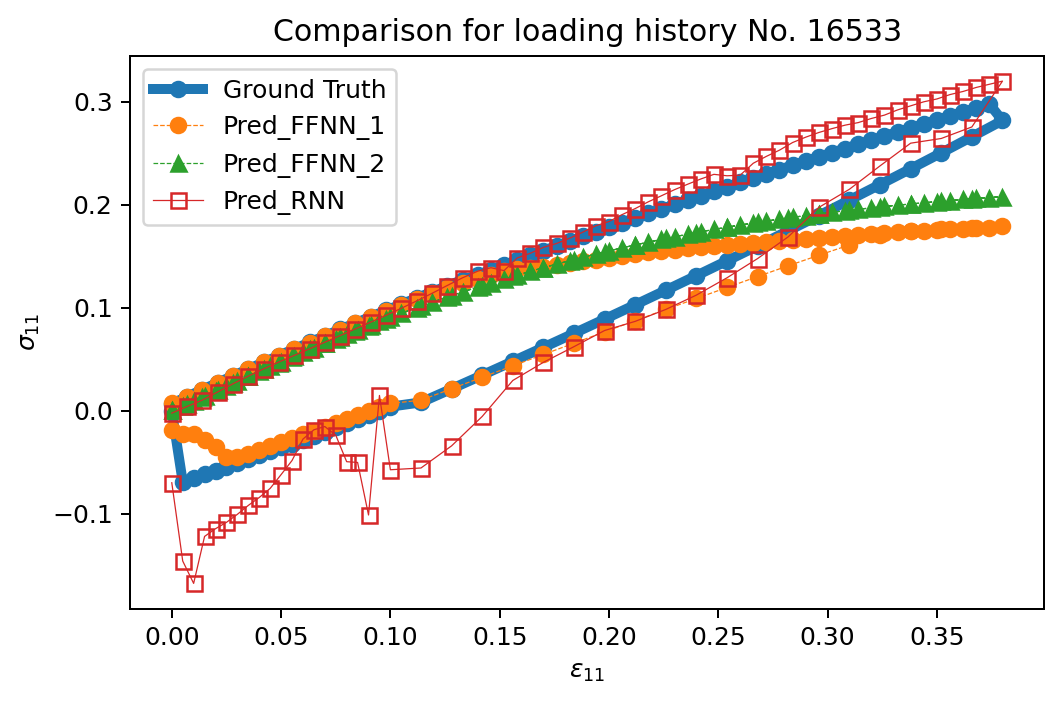

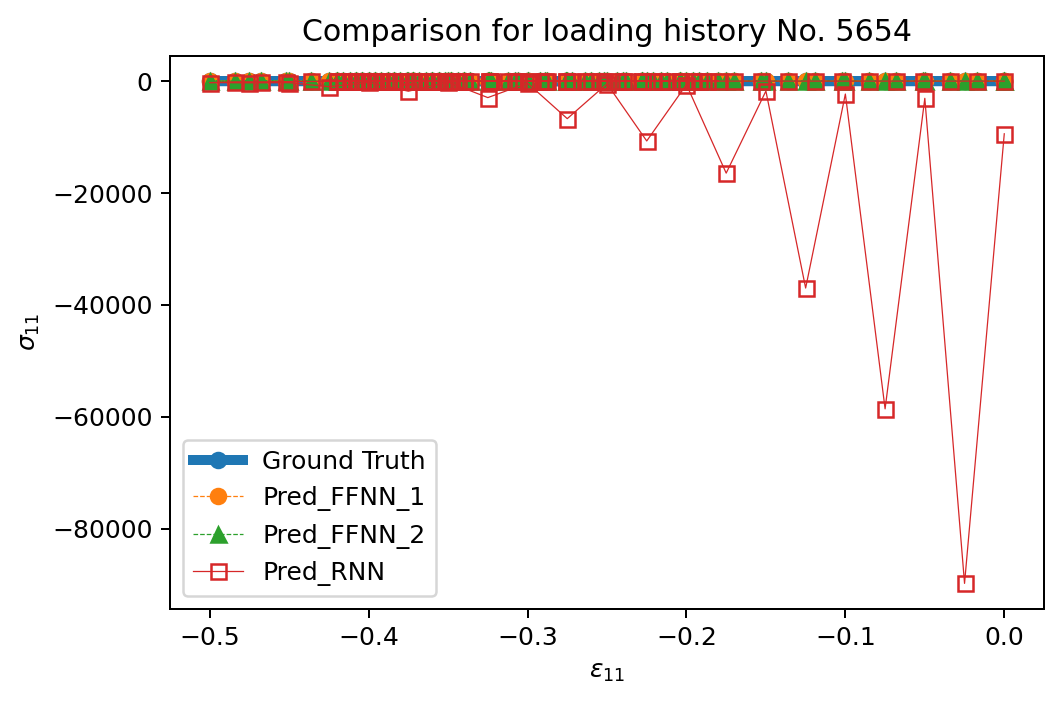

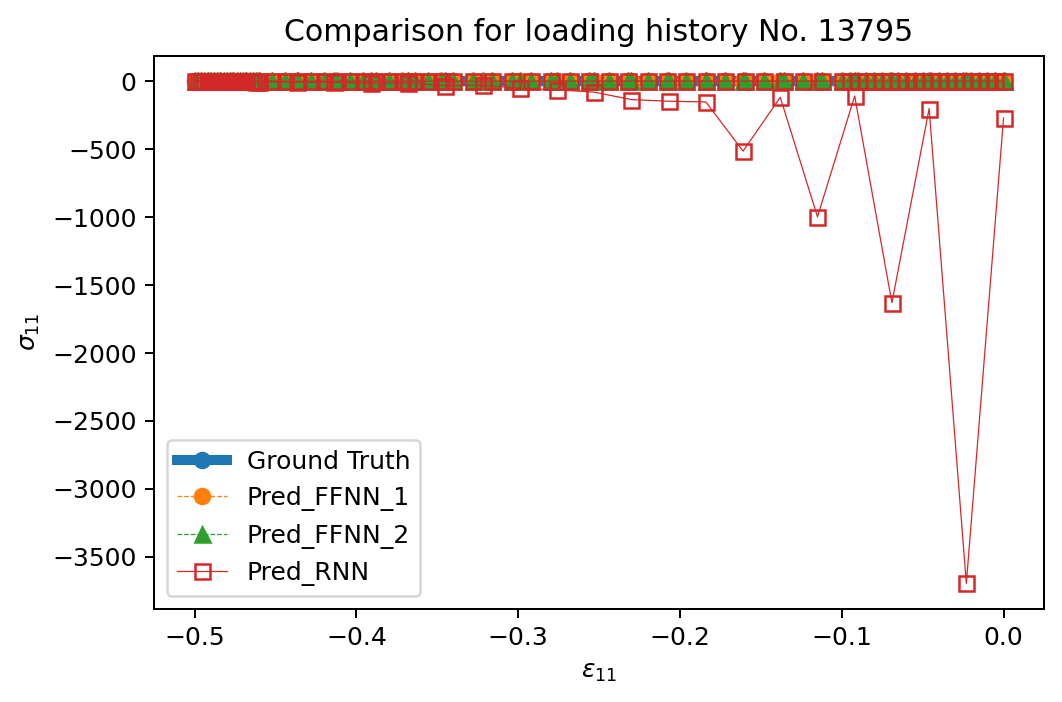

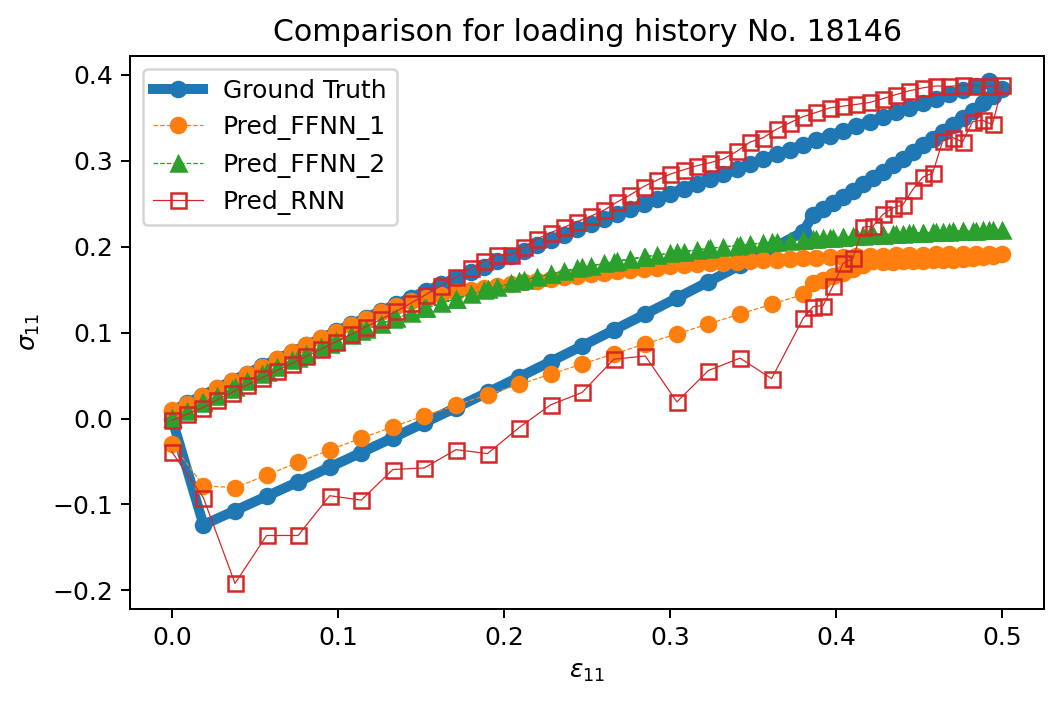

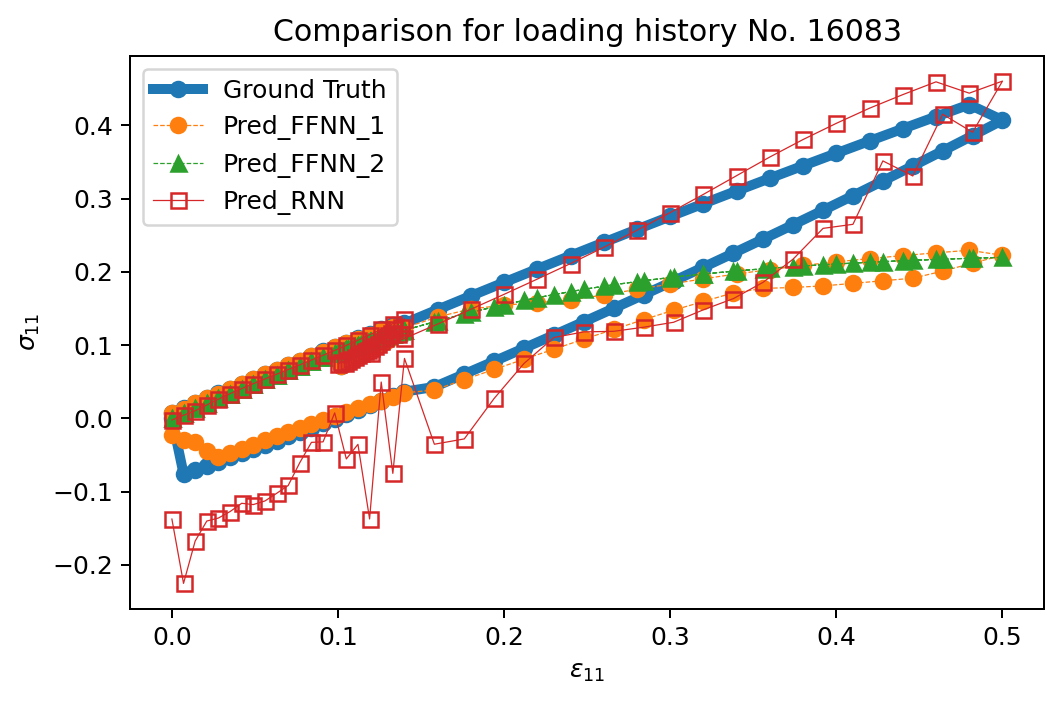

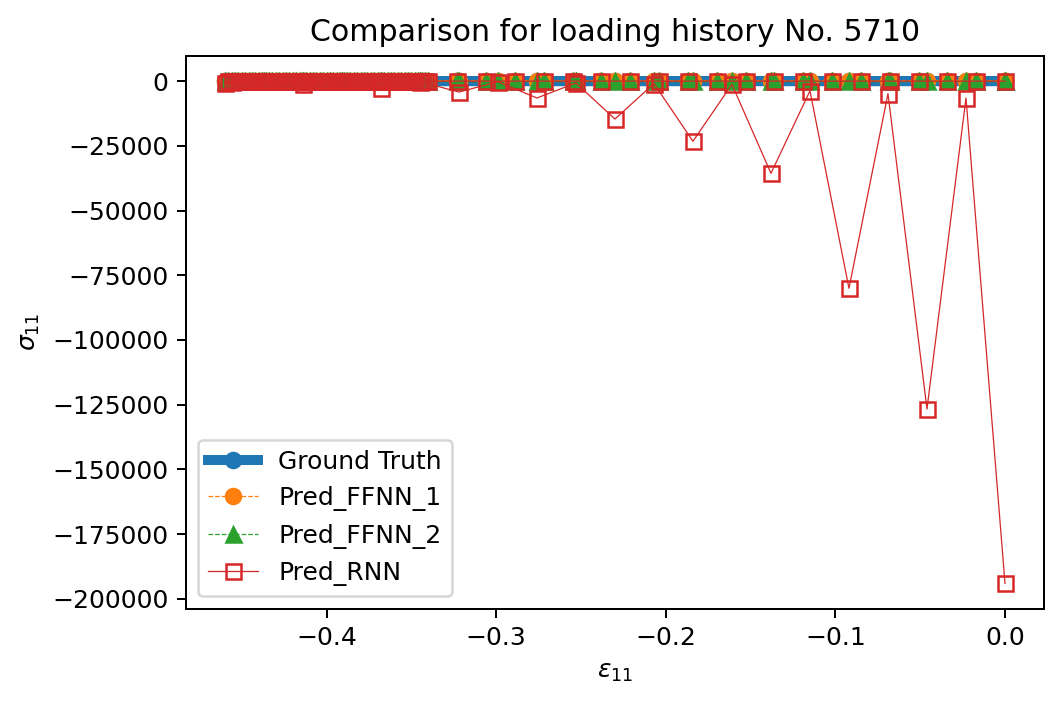

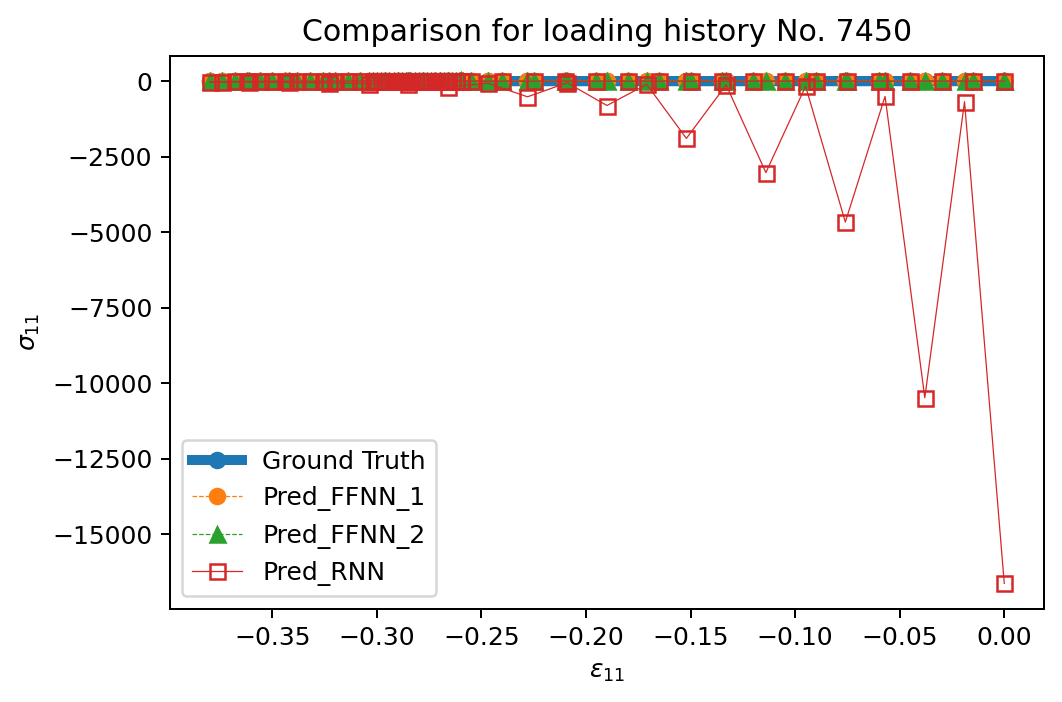

In [149]:
sels = np.random.randint(0, 20001, 20)

for i in sels:
    plot_all(i)

In [2]:

def plot_FFNN_1(sel):
    plt.figure(dpi=180)
    plt.title(f"FFNN_1 prediction for loading No. {sel}")

    plt.plot(x_test[sel*ts:(sel+1)*ts, 0], y_test[sel*ts:(sel+1)*ts,-1], label="Ground Truth", linewidth=4)
    plt.plot(x_test[sel*ts:(sel+1)*ts, 0], y_pred_FFNN_1[sel*ts:(sel+1)*ts,-1], label="Pred_FFNN_1", marker = "o", linestyle='--', linewidth=1)
    
    plt.ylabel("$\sigma_{11}$")
    plt.xlabel("$\epsilon_{11}$")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"./plot/FFNN_1_{sel}.jpg", format="jpg")
    plt.show()
    
def plot_FFNN_2(sel):
    plt.figure(dpi=180)
    plt.title(f"FFNN_2 prediction for loading No. {sel}")

    plt.plot(x_test[sel*ts:(sel+1)*ts, 0], y_test[sel*ts:(sel+1)*ts,-1], label="Ground Truth", linewidth=4)
    plt.plot(x2_test[sel*ts:(sel+1)*ts], y_pred_FFNN_2[sel*ts:(sel+1)*ts], label="Pred_FFNN_2", marker = "o", linestyle='--', linewidth=1)
    
    
    plt.ylabel("$\sigma_{11}$")
    plt.xlabel("$\epsilon_{11}$")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"./plot/FFNN_2_{sel}.jpg", format="jpg")
    plt.show()
    
def plot_RNN(sel):
    plt.figure(dpi=180)
    plt.title(f"RNN prediction for loading No. {sel}")

    plt.plot(x_test[sel*ts:(sel+1)*ts, 0], y_test[sel*ts:(sel+1)*ts,-1], label="Ground Truth", linewidth=4)
    plt.plot(X_test[sel,:], y_pred_RNN[sel], label="Pred_RNN", marker = "o", linestyle='--', linewidth=1)

    plt.ylabel("$\sigma_{12}$")
    plt.xlabel("$\epsilon_{12}$")
    plt.legend()
    plt.tight_layout()
    #plt.savefig(f"./plot/RNN_{sel}.jpg", format="jpg")
    plt.show()

NameError: name 'x_test' is not defined

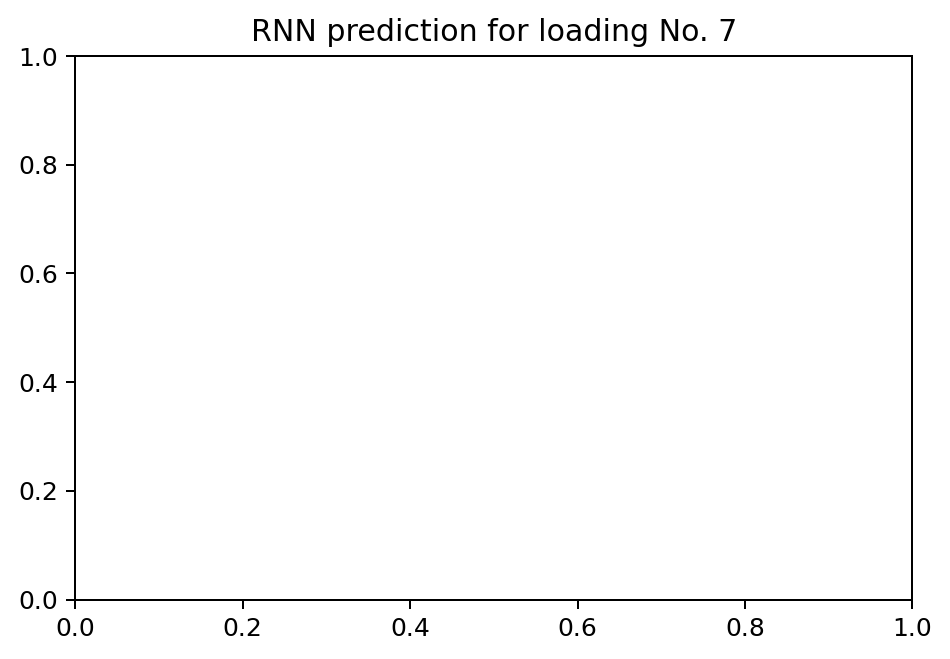

In [3]:
plot_RNN(7)

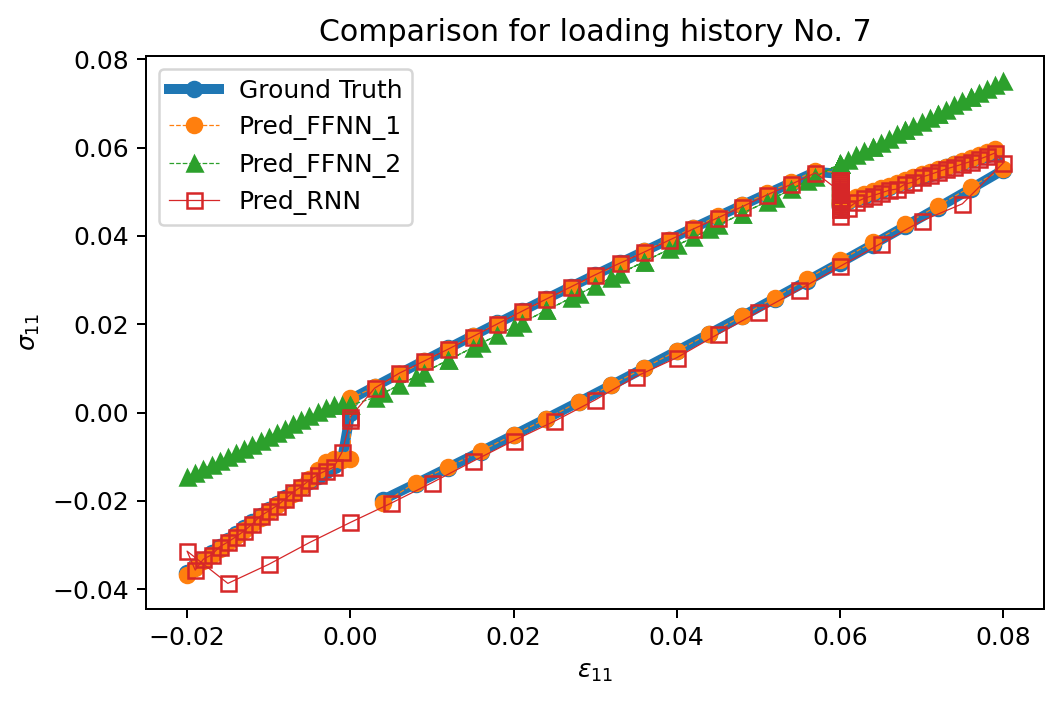

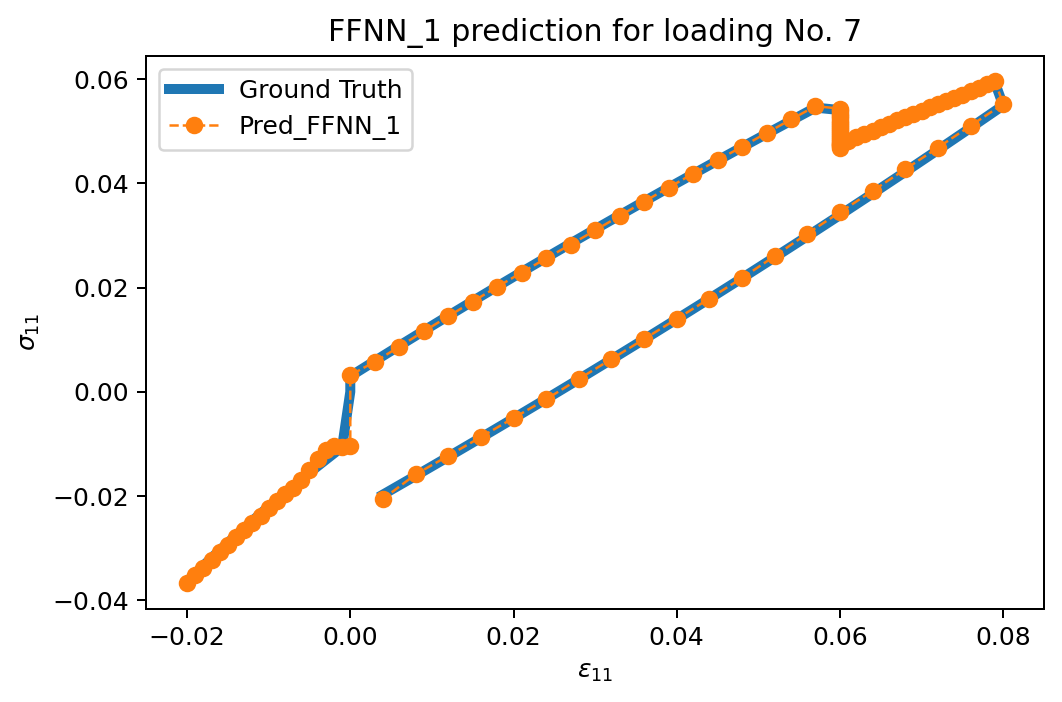

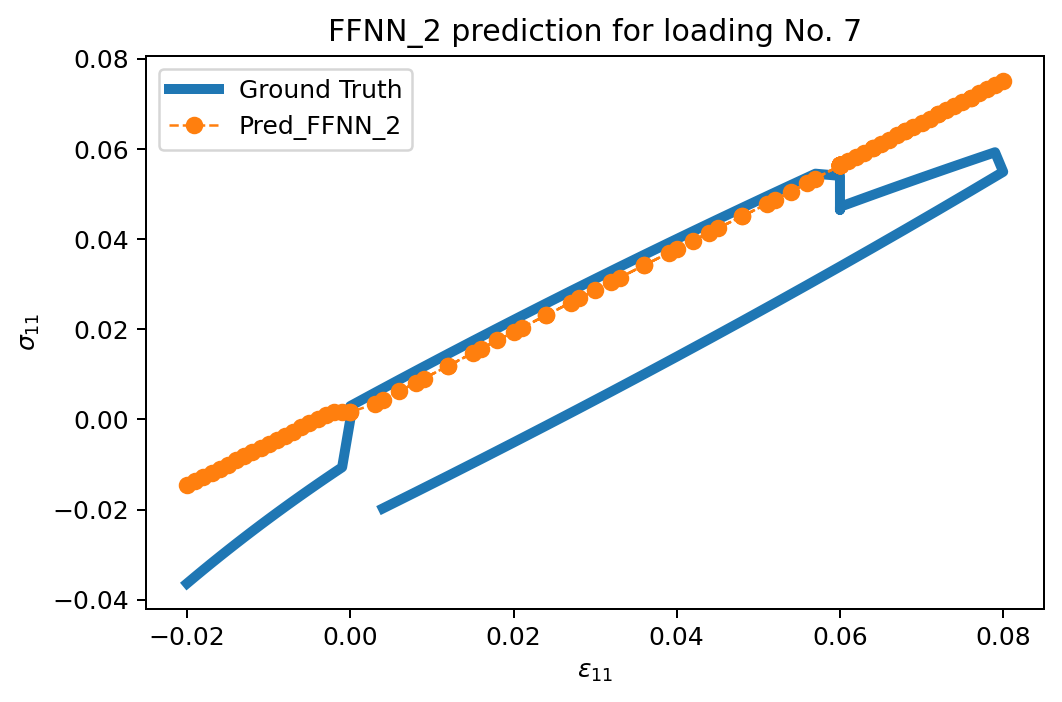

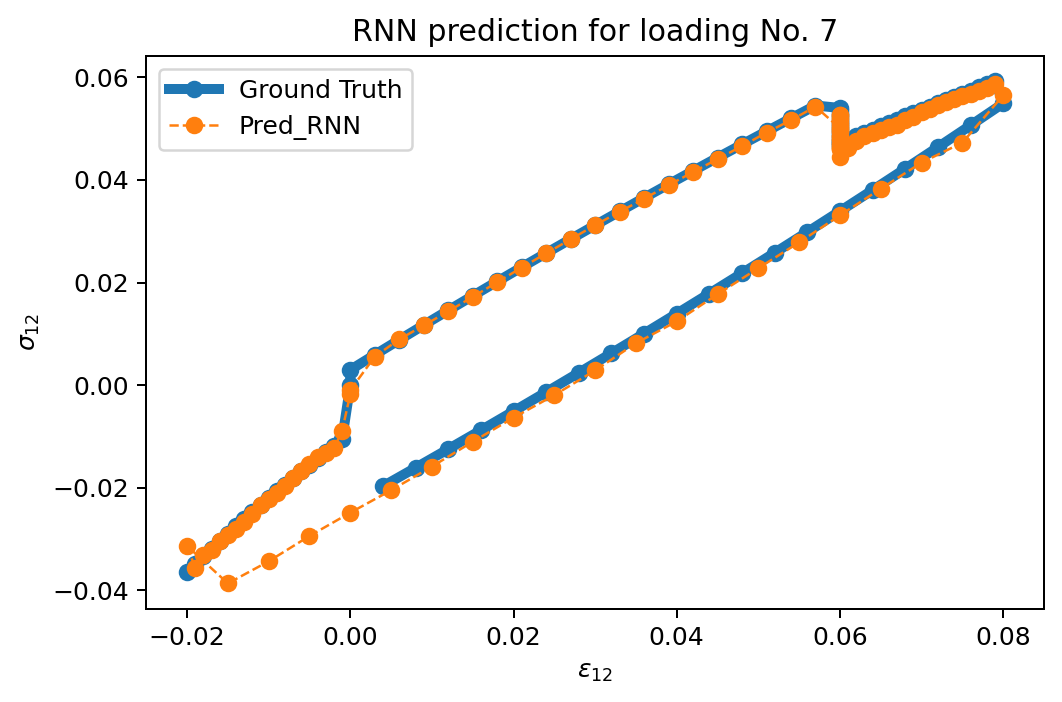

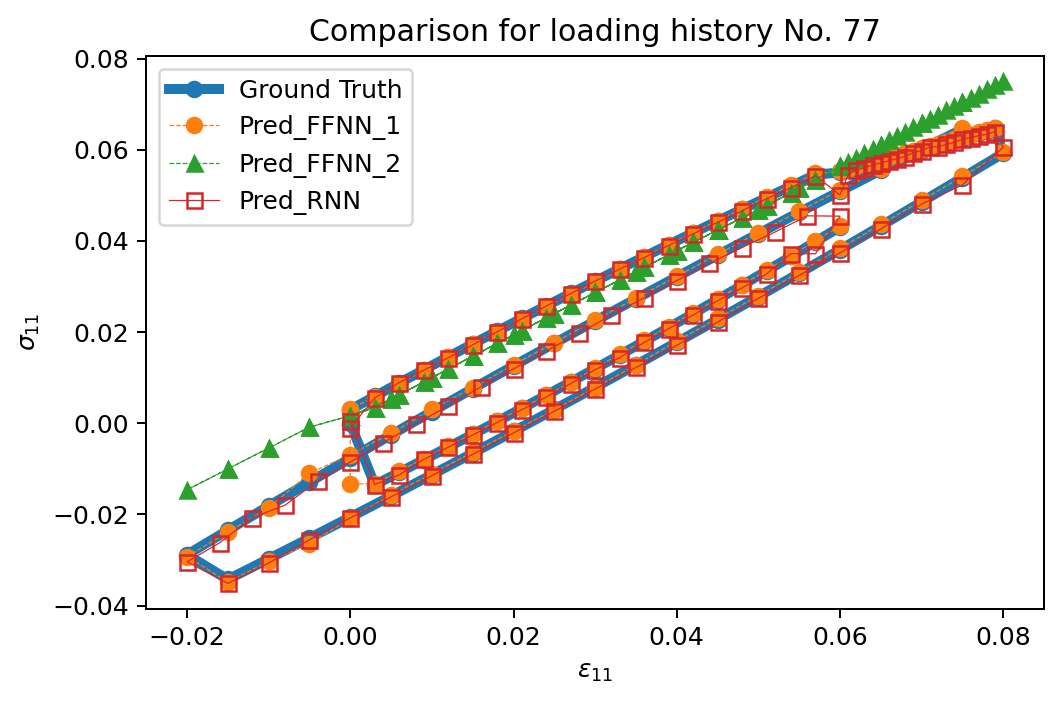

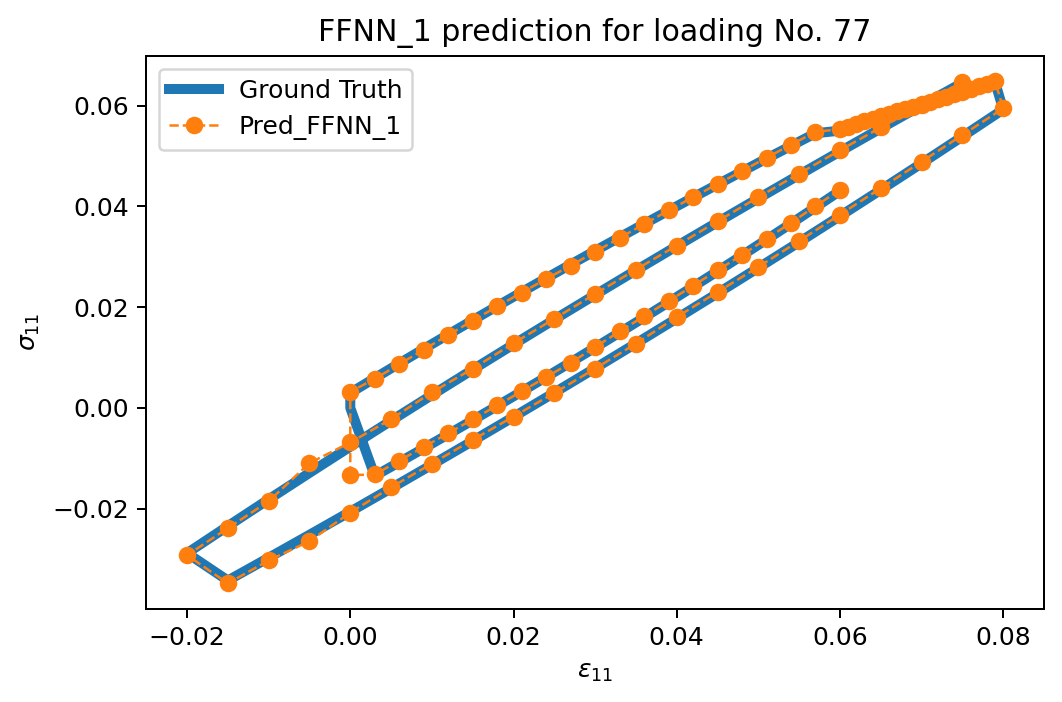

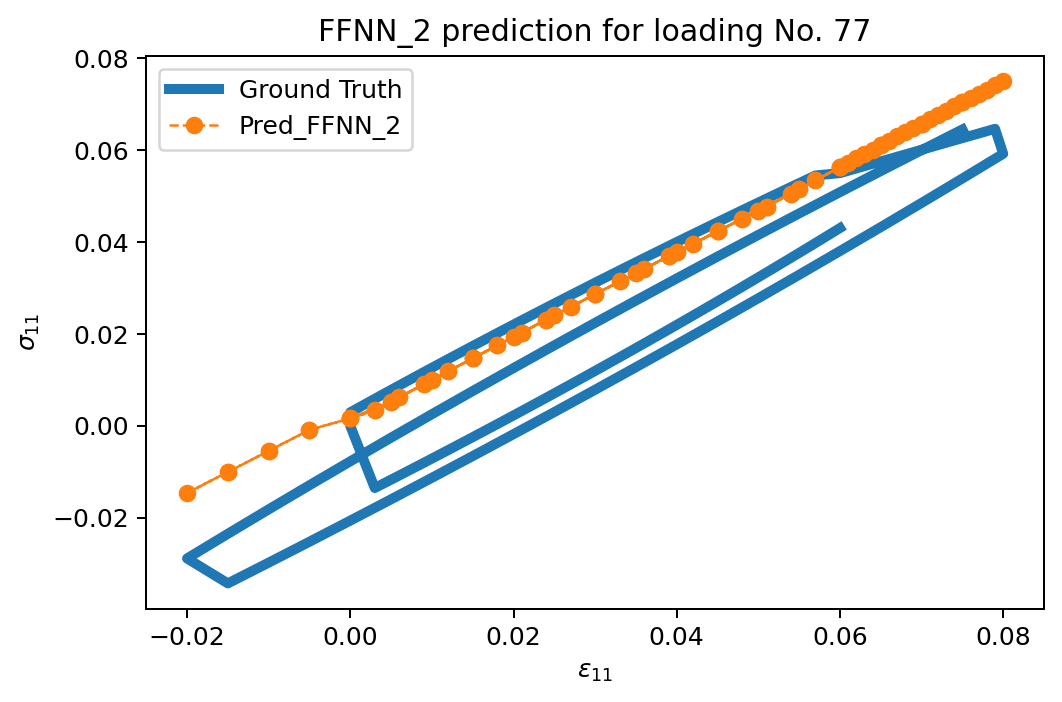

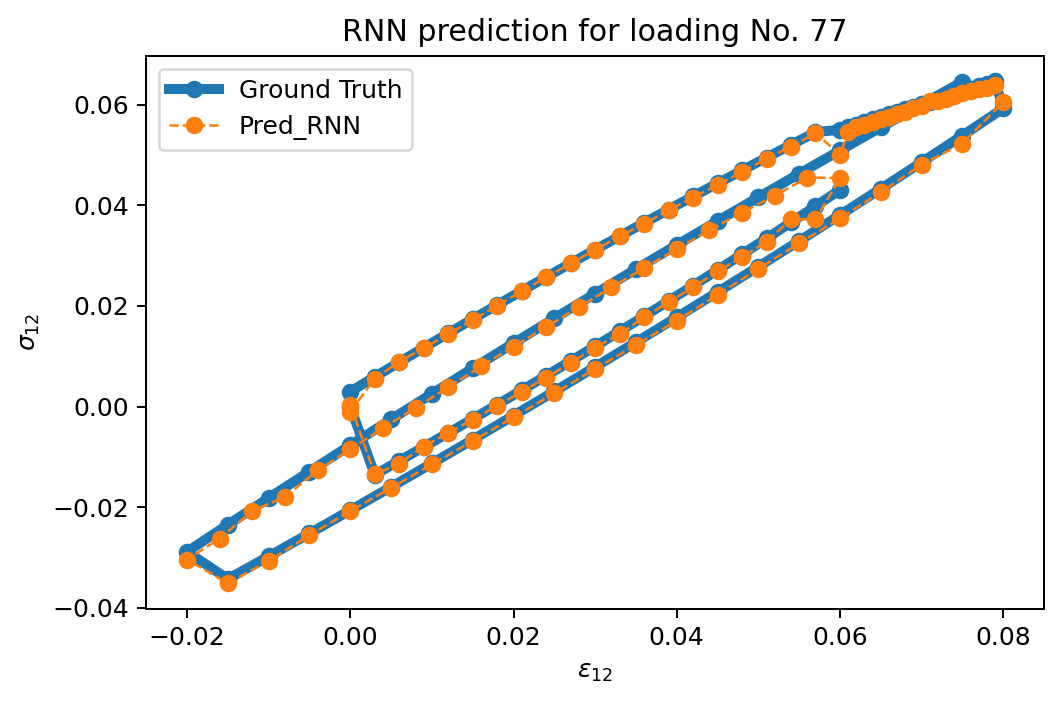

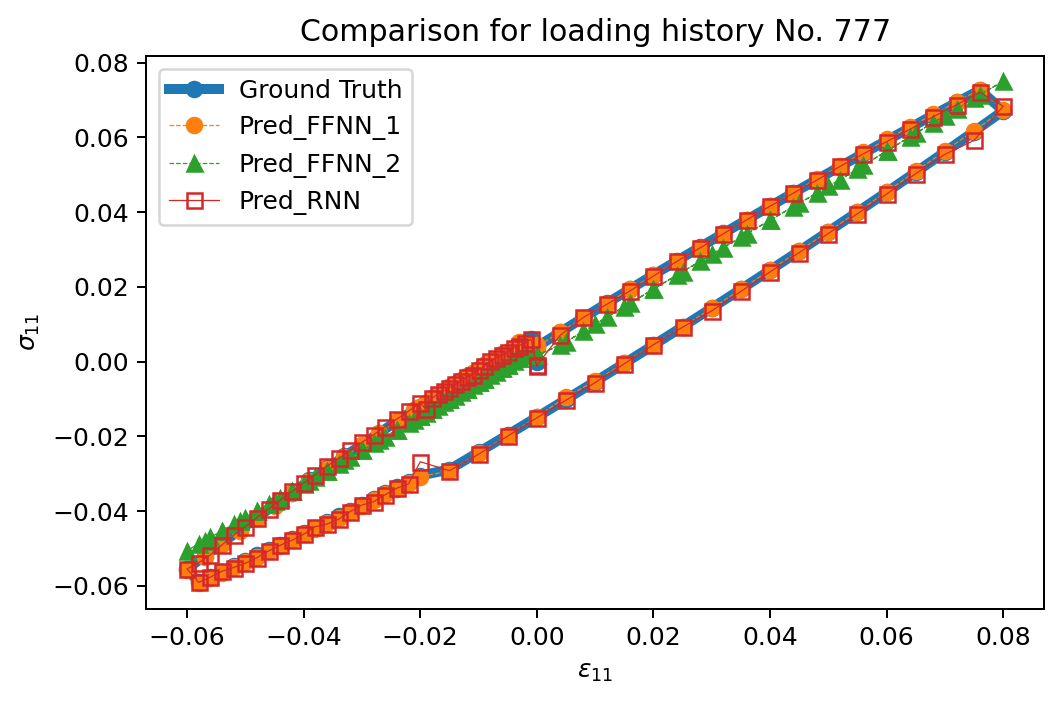

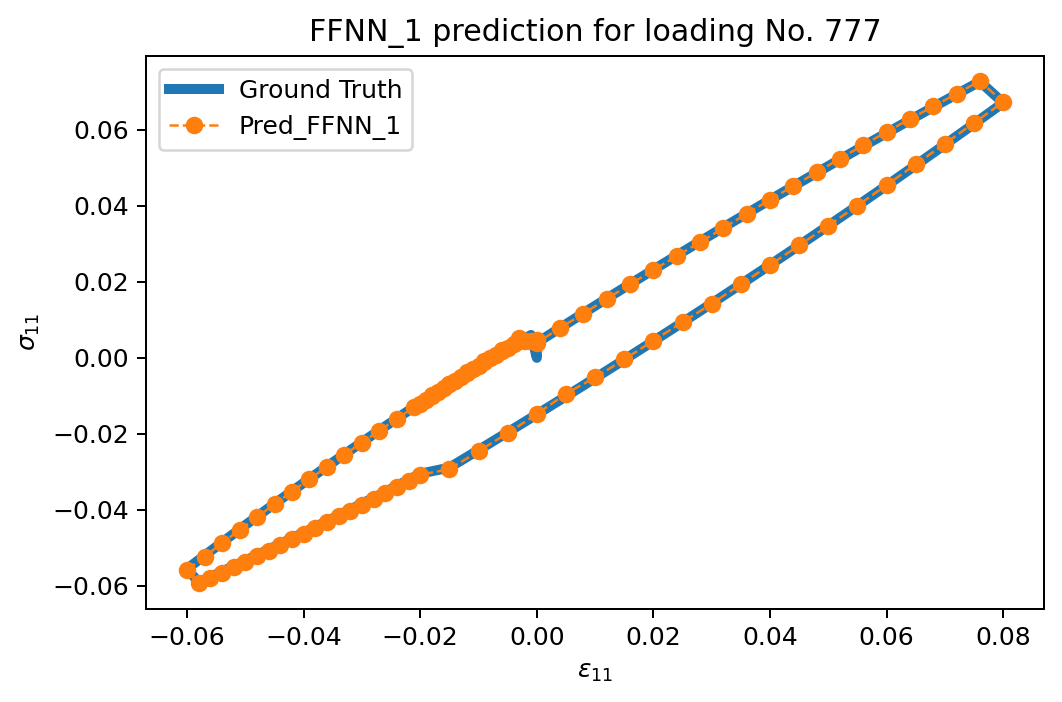

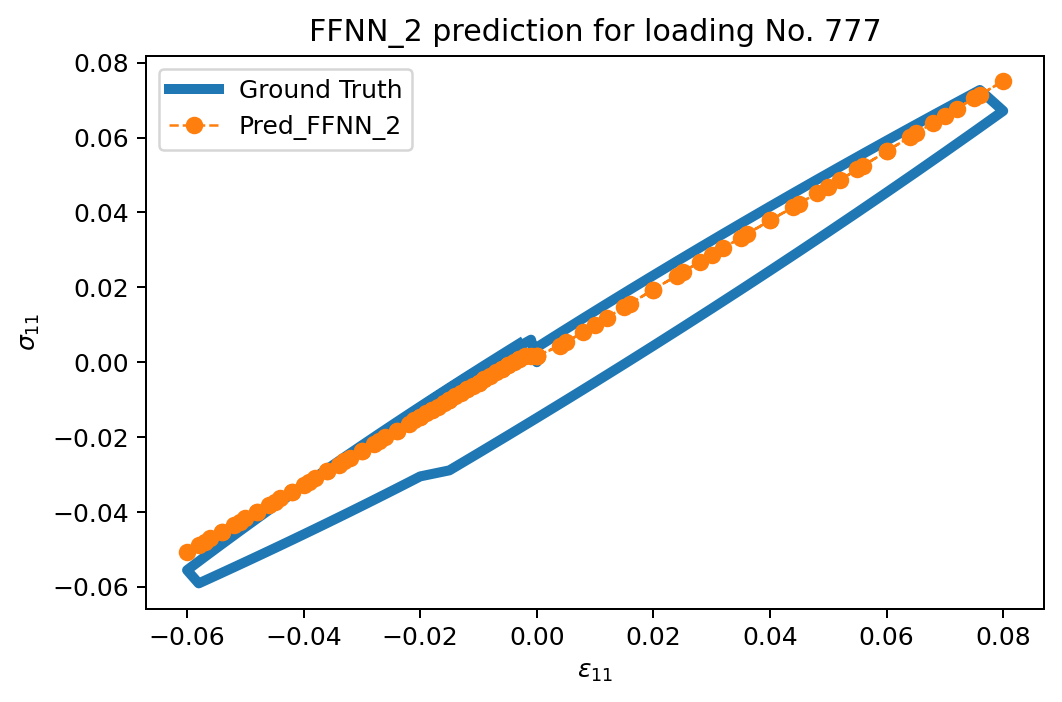

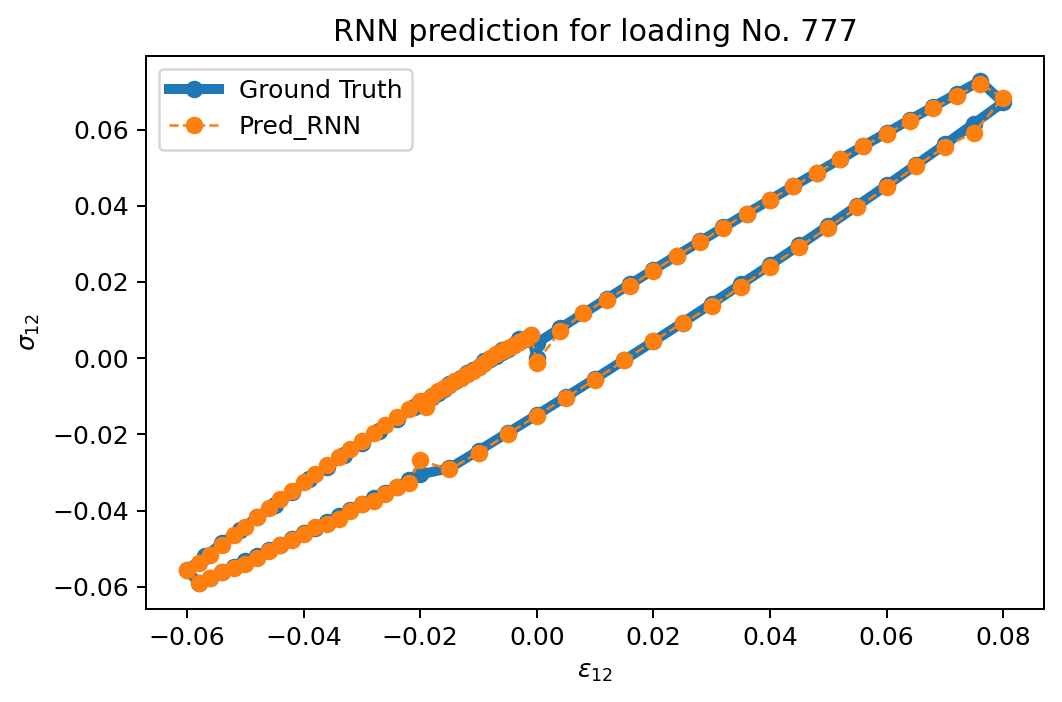

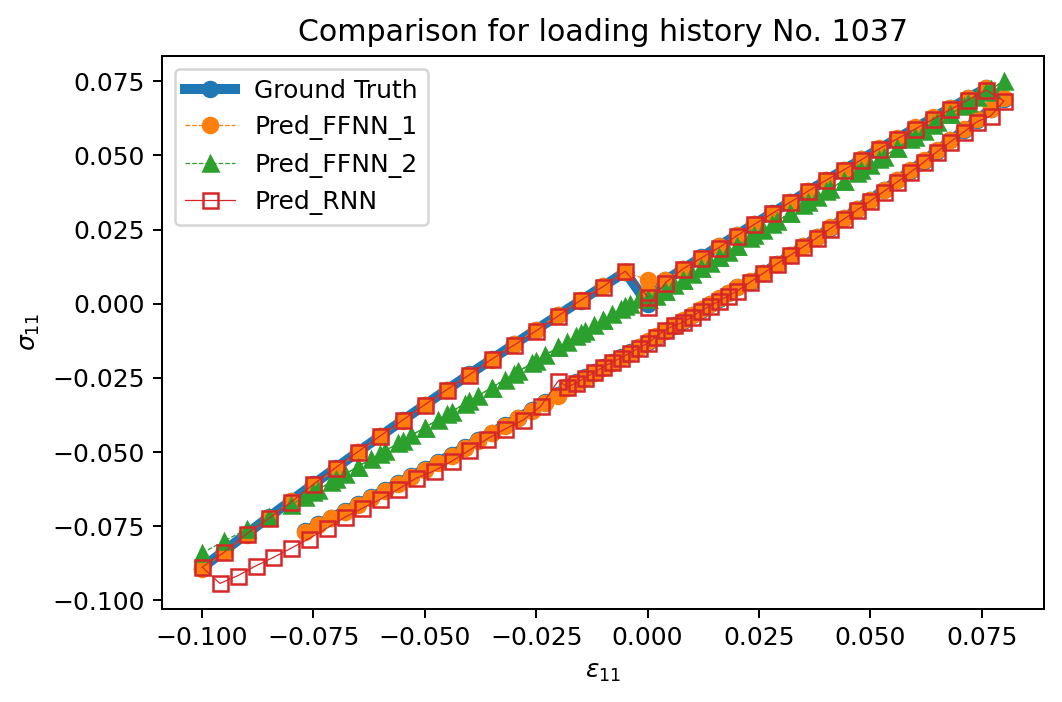

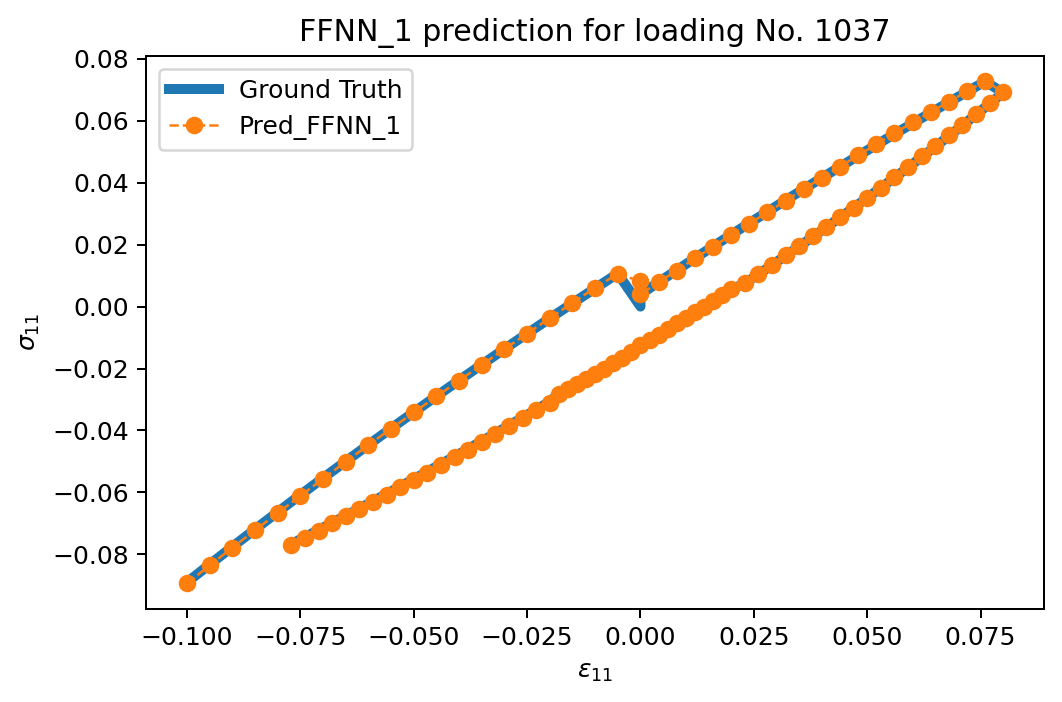

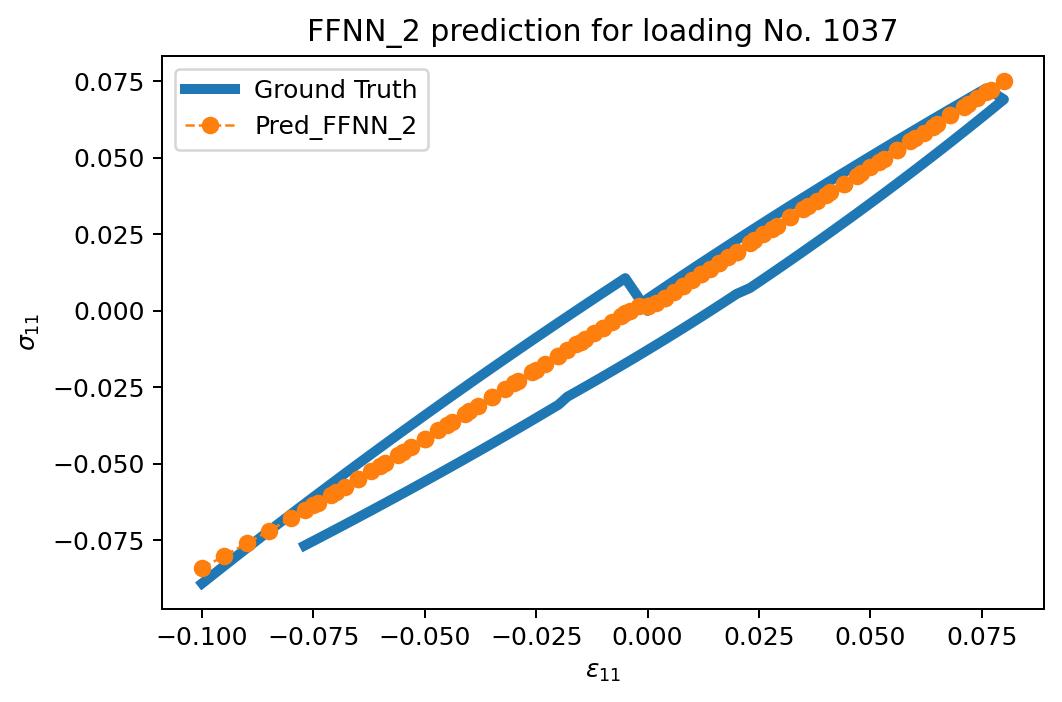

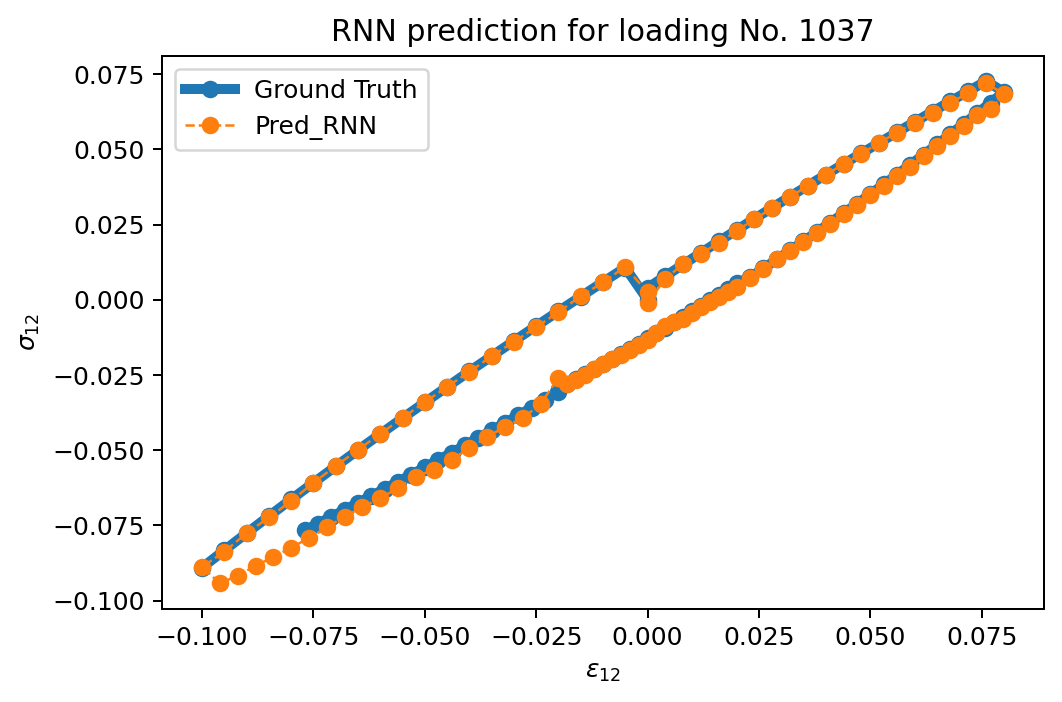

In [209]:
for i in [7, 77, 777, 1037]:
    plot_all(i)
    plot_FFNN_1(i)
    plot_FFNN_2(i)
    plot_RNN(i)
